Filename: /root/.astropy/cache/download/url/e401e561c2d035b05ce5d894e252fcd9/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18684R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


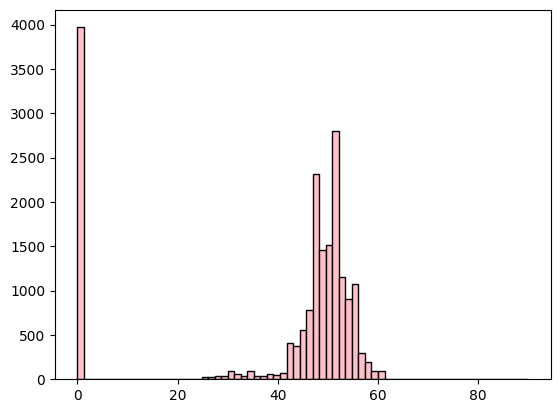

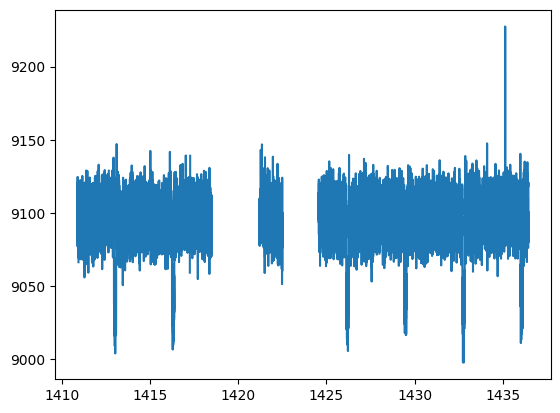

In [46]:
# Import and define data - to be used for visuals and audio generation
import requests
from requests.auth import HTTPBasicAuth
import csv
import plotly.express as px
import pandas as pd
from datetime import datetime
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from mido import MidiFile, MidiTrack, Message
from collections import defaultdict


fits_file = 'https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/tess2018292075959-s0004-0000000025155310-0124-s_lc.fits'
fits.info(fits_file)
fits.getdata(fits_file, ext=1).columns

hdul = fits.open(fits_file)

# Extract data from the first HDU
data = hdul[1].data  # Assuming data is in the first extension

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save DataFrame to a CSV file
csv_file = 'tess_data.csv'  # Replace with your desired CSV file path
df.to_csv(csv_file, index=False)

# Close the FITS file
hdul.close()

# Use the read_csv() function to import the CSV file into a DataFrame.
df = pd.read_csv('tess_data.csv')

# Now, 'df' contains your CSV data as a pandas DataFrame, and you can work with it.
# For example, you can print the first few rows of the DataFrame:
time = df['TIME']
light = df['PDCSAP_FLUX']

#get the range
light_max = light.max()
light_min = light.min()
light_range = light_max - light_min

# Normalize each value to the new range
df['Pitch'] = round((df['PDCSAP_FLUX'] - light_min) / light_range * 70 + 20)
# print(df['Pitch'])

# df['Pitch'] = df['Pitch'].apply(lambda x: np.random.randint(0, max_value) if x > max_value else x)
df['Pitch'].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

# Remove zeros

# Create a histogram
# plt.hist(df['PDCSAP_FLUX'], bins=69, color='pink', edgecolor='black')

# Show plot
# plt.show()

# Create a histogram
plt.hist(df['Pitch'], bins=69, color='pink', edgecolor='black')
plt.show()

plt.plot(time, light)
# Show plot
# plt.show()


# # Create a MIDI file
midi_file = MidiFile()

# Add a track to the MIDI file
track = MidiTrack()
midi_file.tracks.append(track)

# Sort df by ascending Timestamp
df=df.sort_values(by='TIME', ascending=True)

# Remove negative Timestamps
df = df[df['TIME'] >=0]

csv_file_path = 'sonification_proj.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

# # Add notes to the MIDI track with overlapping timestamps
prev_time=0

note_duration = 480  # Adjust this value for longer or shorter notes

# Previous time to calculate time delta
prev_time = df['TIME'].iloc[0]

for index, row in df.iterrows():
    pitch = int(row['Pitch'])
    time_delta = int((row['TIME'] - prev_time) * note_duration)  # Calculate the time delta

    # Add a note_on message
    volume = 0 if pitch == 0 else 100

    # Add a note_on message with the calculated volume
    track.append(Message('note_on', note=pitch, velocity = volume, time=time_delta))

    # Add a note_off message after the note_duration
    track.append(Message('note_off', note=pitch, time=note_duration//6))

    prev_time = row['TIME']

# Specify the output file path and name
output_file = "draft1.mid"

# Save the MIDI file
midi_file.save(output_file)

